In [2]:
import os
import math
import random
import operator
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import math

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from operator import itemgetter

In [3]:
def load_file(data_file_path):
    data_df = pd.read_csv(data_file_path, delimiter=";")
    return data_df


def compute_reward_individual(num_calls, result, cost_per_call = 1):
    if result == "yes":
        return (21 - (cost_per_call * num_calls))
    elif result == "no":
        return (-1 * (cost_per_call * num_calls))
    

def compute_y_position_label(y_val):
    if y_val >= 0.0:
        return 'bottom'
    else:
        return 'top'
    

def div(a,b):
    if int(b) == 0:
        return 0.0
    else:
        return a/b
        

def plot_graph(x, y, key, bar_plot, digregard_x_axis):
    style = dict(size=8, color='red')
    new_x = []
    if digregard_x_axis:
        for i in range(1, len(x)+1):
            new_x.append(i)
    else:
        new_x = x
    fig, ax = plt.subplots(figsize = (14, 6))
    # plt.xticks(np.arange(len(x)), x, rotation=75)
    # ax.tick_params(axis='x', which='major', pad=20)
    if bar_plot:
        ax.bar(new_x, y, 0.75)
    else:
        # plt.xlim((x[0],x[-1]))
        ax.plot(x, y)
    if digregard_x_axis:
        for i in range(1, len(x)+1):
            ax.text(i, y[i-1], x[i-1], ha='center', verticalalignment=compute_y_position_label(y[i-1]), **style)
        ax.axes.get_xaxis().set_visible(False)
    else:
        for i in range(1, len(x)+1):
            ax.text(x[i-1], y[i-1], y[i-1], ha='center', verticalalignment=compute_y_position_label(y[i-1]), **style)
    # Setting title and labels.
    title = "Expected reward vs " +  str(key)
    ax.set(xlabel=str(key), ylabel='Expected Reward', title=title)
    # plt.axvline(x=0, color ="black")
    plt.axhline(y=0, color ="black")
    # ax.grid()
    plt.tight_layout()
    plt.show()
    

def plot_graph_balance(x, y, key, step):
    style = dict(size=8, color='black')
    fig, ax = plt.subplots(figsize = (14, 6))
    # plt.xticks(np.arange(len(x)), x, rotation=75)
    # ax.tick_params(axis='x', which='major', pad=20)
    ax.bar(x, y, 0.75)
    # Setting title and labels.
    title = "Expected reward vs " +  str(key)
    ax.set(xlabel= "Average yearly balance", ylabel='Expected Reward', title=title)
    # plt.axvline(x=0, color ="black")
    plt.axhline(y=0, color ="black")
    # ax.grid()
    plt.tight_layout()
    tick_labels = ['-ve', '-ve', '-ve']
    for i in range (1, len(x)+1):
        tick_labels.append(str((i-1)*step) +'-' + str(i * step))
    ax.set_xticklabels(tick_labels ,rotation='vertical')
    plt.show()


def analyze_results(reward_values_list_sorted):
    num_pos = 0
    num_neg = 0
    num_pos_avg = 0.0
    num_neg_avg = 0.0
    for item in reward_values_list_sorted:
        ref = item[1]
        if ref['expected'] >= 0.0:
            num_pos += 1
            num_pos_avg += ref['expected']
        else:
            num_neg += 1
            num_neg_avg += ref['expected']
    print("# Positive: ", num_pos)
    print("# Negative:", num_neg)
    print("Pos - Avg. Expected:", div(num_pos_avg,num_pos))
    print("Neg - Avg. Expected:", div(num_neg_avg,num_neg))

In [4]:
def compute_plot_value_rows_by_key(mkt_df, key, bar_plot, digregard_x_axis):
    values = mkt_df[key].unique()
    reward_values ={}
    total_count = 0
    total_value = 0.0
    for value_ref in values:
        reward_values[value_ref] = {'value':0.0, 'y_count':0, 'n_count':0, 'expected':None}
    for index, row in mkt_df.iterrows():
        value_ref = row[key]
        reward_values[value_ref]['value'] += (compute_reward_individual(row['campaign'], row['y']))
        if row['y'] == "yes":
            reward_values[value_ref]['y_count'] += 1
        elif row['y'] == "no":
            reward_values[value_ref]['n_count'] += 1
        total_count += 1
    for item in reward_values:
        ref = reward_values[item]
        total_value += ref['value']
        ref['expected'] = div(ref['value'], (ref['y_count'] + ref['n_count']))
    reward_values_list = reward_values.items()
    print(reward_values_list)
    # For age use: tup[0] and sorted = False
    reward_values_list_sorted = sorted(reward_values_list, key=lambda tup: tup[1]['expected'], reverse=True)
    print("Total Value is:", total_value)
    x = []
    y = []
#     print("List of x,y pairs: ")
    i = 1
    for item in reward_values_list_sorted:
        print(item, end='\n')
        if i%6 == 0:
            print("\n")
        x.append(item[0])
        y.append((item[1]['expected']))
        i += 1
#     analyze_results(reward_values_list_sorted)
#     print("Y is:")
#     print(y)
    plot_graph(x, y, key, bar_plot, digregard_x_axis)

    
def compute_plot_balance_value(mkt_df, step = 2500):
    min = mkt_df['balance'].values.min()
    max = mkt_df['balance'].values.max()
    reward_value = {}
    total_count = 0
    for i in range(min, max, step):
        reward_value[(int(i/step))] = {'value':0.05, 'count':0}
#         print("Max is:", max)
    for index, row in mkt_df.iterrows():
        bal = row['balance']
        bal_index = None
        if bal <0.0:
            bal_index = -1
        else:
            bal_index = int(bal/step)
        reward_value[bal_index]['value'] += compute_reward_individual(row['campaign'], row['y'])
        reward_value[bal_index]['count'] += 1
        total_count += 1
    x = [str(key) for key in reward_value.keys()]
    y = [div(item['value'],item['count']) for item in reward_value.values()]
#     print(reward_value)
    plot_graph_balance(x, y, 'balance', step)

In [5]:
# This function takes the data corresponding to a feature set and computes the expected values for calls
# ranging from 1 .. 10.
def compute_expected_reward_feature_set(fs_df, no_calls):
    expected_values_calls = []
    for i in range(0, no_calls):
        expected_values_calls.append({'value':0.0, 'count':0, 'expected':0.0})
    for index, row in fs_df.iterrows():
        expected_values_calls[row['campaign']-1]['value'] += compute_reward_individual(row['campaign'], row['y'])
        expected_values_calls[row['campaign']-1]['count'] += 1
    for i in range(0, no_calls):
        expected_values_calls[i]['expected'] = div(expected_values_calls[i]['value'], expected_values_calls[i]['count'])
    return expected_values_calls

In [28]:
# Given a dictionary of what attributes comprise a feature set, we can get all rows corresponding to this feature set.
def extract_rows_feature_set(fs_df, feature_labels = {'education':['tertiary', 'unknown'], 
                                                      'job':['management', 'technician', 'blue-collar'], 
                                                      'marital':['single'], 'default':['no'], 
                                                      'housing':['no'], 'loan':['no']}):
    for key in feature_labels:
        feature_labels_query_str = ''
        arr = feature_labels[key]
        for label in arr:
            feature_labels_query_str += (key + ' == "'+ label + '" | ')
        feature_labels_query_str = feature_labels_query_str[:-3]
        fs_df = fs_df.query(feature_labels_query_str)
    return fs_df

Entire Dataframe:  45211
Filtered Dataframe with calls from 1 to 20:  44967
Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')
[{'value': 3269.0, 'count': 553, 'expected': 5.9113924050632916}, {'value': 1400.0, 'count': 497, 'expected': 2.816901408450704}, {'value': 114.0, 'count': 165, 'expected': 0.6909090909090909}, {'value': -191.0, 'count': 158, 'expected': -1.2088607594936709}, {'value': -103.0, 'count': 71, 'expected': -1.4507042253521127}, {'value': -219.0, 'count': 61, 'expected': -3.5901639344262297}, {'value': -105.0, 'count': 33, 'expected': -3.1818181818181817}, {'value': -56.0, 'count': 28, 'expected': -2.0}, {'value': -111.0, 'count': 17, 'expected': -6.529411764705882}, {'value': -90.0, 'count': 9, 'expected': -10.0}, {'value': -68.0, 'count': 10, 'expected': -6.8}, {'value': -84.0, 'count': 7, 'expected': -12.0

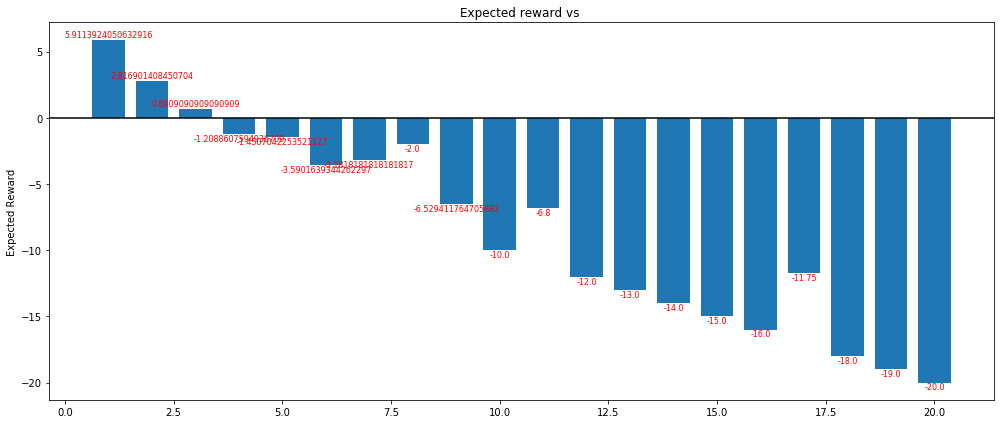

In [41]:
current_dir = os.getcwd()
mkt_df = load_file(current_dir + '/bank-full.csv')
print("Entire Dataframe: ", len(mkt_df))
mkt_df_filtered = mkt_df[(mkt_df['campaign']>=1) & (mkt_df['campaign']<=20)]
print("Filtered Dataframe with calls from 1 to 20: ", len(mkt_df_filtered))
print(mkt_df_filtered.columns)


mkt_df_filtered = mkt_df_filtered.query('age >= 26 & age <=60')
result_df = extract_rows_feature_set(mkt_df_filtered)
# print(len(result_df))
result_graph_data = compute_expected_reward_feature_set(result_df, 20)
print(result_graph_data)
x = []
y = []
i = 0
for item in result_graph_data:
    i+=1
    x.append(i)
    y.append(item['expected'])
plot_graph(x, y, '', True, False)



# This is working.
# result = extract_rows_feature_set(mkt_df_filtered)
# compute_plot_value_rows_by_key(mkt_df_filtered, 'age', True, True)
# compute_plot_value_rows_by_key(mkt_df_filtered, 'education', True, False)
# compute_plot_value_rows_by_key(mkt_df_filtered, 'marital', True, False)
# compute_plot_value_rows_by_key(mkt_df_filtered, 'job', True, False)
# compute_plot_value_rows_by_key(mkt_df_filtered, 'default', True, False)
# compute_plot_value_rows_by_key(mkt_df_filtered, 'housing', True, False)
# compute_plot_value_rows_by_key(mkt_df_filtered, 'loan', True, False)
# compute_plot_balance_value(mkt_df_filtered)

In [8]:
# print(len(mkt_df_filtered[(mkt_df_filtered['education'] == 'secondary') & (mkt_df_filtered['y'] == 'yes')]))
# print(len(mkt_df_filtered[(mkt_df_filtered['education'] == 'secondary') & (mkt_df_filtered['y'] == 'no')]))
# total_v = 0.0
# for index, row in mkt_df_filtered.iterrows():
#     if row['education'] == 'secondary':
#         if row['y'] == "yes":
#             total_v += (11 - row['campaign'])
#         else:
#             total_v -= (row['campaign'])
# print(total_v)
# print()

In [ ]:
#Important information about dataset.
print(len(mkt_df_filtered[mkt_df_filtered['y']=="yes"]))
print(len(mkt_df_filtered[mkt_df_filtered['y']=="no"]))

In [ ]:
my_str =  'education == "unknown"'
mkt_df_filtered.query(my_str)

In [36]:
len(mkt_df_filtered.query('job == "unknown"'))

274

In [30]:
mkt_df_filtered.query('age == 93')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
44262,93,retired,married,unknown,no,775,no,no,cellular,22,jul,860,2,177,7,success,yes
44420,93,retired,married,unknown,no,775,no,no,cellular,4,aug,476,2,13,9,success,yes


In [25]:
result_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
173,35,retired,single,primary,no,434,no,no,unknown,5,may,138,1,-1,0,unknown,no
318,40,retired,single,primary,no,0,no,no,unknown,5,may,136,2,-1,0,unknown,no
1511,27,student,single,secondary,no,0,no,no,unknown,8,may,93,2,-1,0,unknown,no
1544,33,unemployed,single,secondary,no,177,no,no,unknown,8,may,75,4,-1,0,unknown,no
1804,39,retired,single,primary,no,-79,no,no,unknown,9,may,180,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45066,29,student,single,secondary,no,1925,no,no,cellular,21,oct,150,3,149,5,success,yes
45068,26,student,single,secondary,no,108,no,no,cellular,21,oct,235,1,175,3,success,no
45071,27,unemployed,single,secondary,no,771,no,no,cellular,21,oct,181,1,302,3,other,yes
45080,27,student,single,secondary,no,1164,no,no,cellular,21,oct,256,2,104,2,failure,no


[{'calls': 1, 'reward': 36237.0, 'num': 17544}, {'calls': 2, 'reward': 4411.0, 'num': 12505}, {'calls': 3, 'reward': -3585.0, 'num': 5521}, {'calls': 4, 'reward': -7431.0, 'num': 3522}, {'calls': 5, 'reward': -5901.0, 'num': 1764}, {'calls': 6, 'reward': -5814.0, 'num': 1291}, {'calls': 7, 'reward': -4158.0, 'num': 735}, {'calls': 8, 'reward': -3648.0, 'num': 540}, {'calls': 9, 'reward': -2502.0, 'num': 327}, {'calls': 10, 'reward': -2366.0, 'num': 266}, {'calls': 11, 'reward': -1875.0, 'num': 201}, {'calls': 12, 'reward': -1776.0, 'num': 155}, {'calls': 13, 'reward': -1603.0, 'num': 133}, {'calls': 14, 'reward': -1218.0, 'num': 93}, {'calls': 15, 'reward': -1176.0, 'num': 84}, {'calls': 16, 'reward': -1222.0, 'num': 79}, {'calls': 17, 'reward': -1047.0, 'num': 69}, {'calls': 18, 'reward': -918.0, 'num': 51}, {'calls': 19, 'reward': -836.0, 'num': 44}, {'calls': 20, 'reward': -839.0, 'num': 43}]


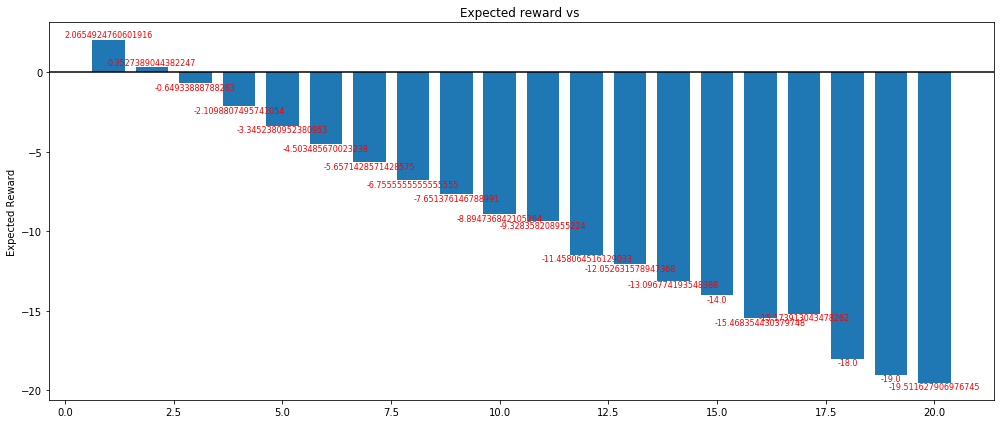

In [58]:
total_v = 0.0
num_success = 0
all_results = []
for i in range(1,21):
    all_results.append({'calls':i, 'reward':0.0, 'num':0})
for index, row in mkt_df_filtered.iterrows():
    num_calls = row['campaign']
    all_results[num_calls-1]['reward'] += compute_reward_individual(num_calls, row['y'])
    all_results[num_calls-1]['num'] += 1
print(all_results)
x = []
y = []
i = 0
for item in all_results:
    i +=1 
    x.append(i)
    y.append(item['reward']/item['num'])
plot_graph(x, y, '', True, False)

In [23]:
# USE v as 20 and max calls as 20
import itertools

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = iterable
    return itertools.chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


def construct_dict(feature_comb):
    new_dict = {}
    new_dict['education'] = feature_comb[0]
    new_dict['job'] = feature_comb[2]
    new_dict['marital'] = feature_comb[1]
    new_dict['default'] = feature_comb[3]
    new_dict['loan'] = feature_comb[4]
    new_dict['housing'] = feature_comb[5]
    return new_dict

In [25]:
# Constructing All Possible Combinations
poss = []
poss.append([['tertiary', 'unknown'],['primary','secondary']])
poss.append([['single'],['married'],['divorced']])
poss.append([['student','retired','unemployed'],['admin', 'management', 'self-employed'],['technician', 'unknown', 'services'],['housemaid', 'blue-collar', 'entrepreneur']])
poss.append([['no'],['yes']])
poss.append([['no'],['yes']])
poss.append([['no'],['yes']])
all_combs = list(itertools.product(*poss))
print(len(all_combs))

192


In [26]:
construct_dict(all_combs[0])

{'education': ['tertiary', 'unknown'],
 'job': ['student', 'retired', 'unemployed'],
 'marital': ['single'],
 'default': ['no'],
 'loan': ['no'],
 'housing': ['no']}

In [30]:
extract_rows_feature_set(mkt_df_filtered, construct_dict(all_combs[0]))

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
5926,29,student,single,tertiary,no,0,no,no,unknown,26,may,52,3,-1,0,unknown,no
5944,30,unemployed,single,tertiary,no,306,no,no,unknown,26,may,372,14,-1,0,unknown,no
8145,30,student,single,unknown,no,809,no,no,unknown,2,jun,91,2,-1,0,unknown,no
9829,45,retired,single,tertiary,no,212,no,no,unknown,9,jun,63,1,-1,0,unknown,no
10273,37,unemployed,single,tertiary,no,1706,no,no,unknown,12,jun,542,3,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44937,26,unemployed,single,tertiary,no,3466,no,no,cellular,6,oct,275,2,-1,0,unknown,yes
44968,27,student,single,tertiary,no,838,no,no,cellular,11,oct,162,1,-1,0,unknown,no
45048,32,student,single,tertiary,no,922,no,no,cellular,18,oct,338,2,-1,0,unknown,no
45158,34,student,single,unknown,no,2321,no,no,cellular,9,nov,600,2,99,5,failure,no


In [40]:
rows = mkt_df_filtered.query('(education == "tertiary" | education == "unknown") and (marital == "single") and (job == "student" | job == "retired" | job == "unemployed") and (housing == "no") and (loan == "no") and (default == "no") and (age < 26) and (balance <= 5000)')
print(len(rows))
total_value = 0.0
for index, row in rows.iterrows():
    if row['y'] == "yes":
        total_value += 21 - row['campaign']
    else:
        total_value += -(row['campaign'])
print(total_value)






91
647.0
